 # Trying out PyTorch Lightning
 In this post I was trying out PyTorch Lightning to see if it's a library that should be used by default alongside PyTorch.
 I will create the same nonlinear probabilistic network from before, but this time using Lightning.
 Hence the first few steps are the same as previously shown.

 Import stuff:

In [1]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

 Let's generate some data with non-linearities that would pose some issues for a linear regression solution:

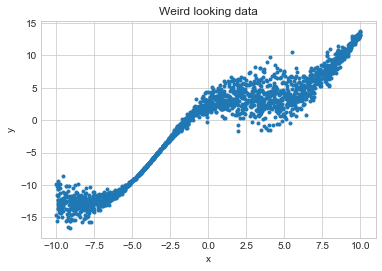

In [2]:
# amount of noise that is added is a function of x
n = 2000
x = np.random.uniform(-10, 10, size=n)
noise_std = np.sin(x * 0.4) + 1
y = (
    -0.5
    + 1.3 * x
    + 3 * np.cos(x * 0.5)
    + np.random.normal(loc=0, scale=noise_std)
)

x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

plt.plot(x, y, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Weird looking data")
plt.show()

 Next we prep data for PyTorch by converting to Tensors and
 creating dataloaders to sort out training batches for us.

In [3]:
from torch.utils.data import TensorDataset, DataLoader

x_train_t = torch.Tensor(x_train[:, np.newaxis])
y_train_t = torch.Tensor(y_train[:, np.newaxis])
x_test_t = torch.Tensor(x_test[:, np.newaxis])
y_test_t = torch.Tensor(y_test[:, np.newaxis])

dataset_train = TensorDataset(x_train_t, y_train_t)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_test = TensorDataset(x_test_t, y_test_t)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

 Next we define various helper functions to help train our models.
 In this case pytorch lightning has taken away much of the boiler plate, so
 the number of functions required for training is essentially just our loss.

In [4]:
def loss_fn_loglike(y_hat, y):
    negloglik = -y_hat.log_prob(y)
    return torch.mean(negloglik)


def plot_loss(loss_train, loss_test):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.array(loss_train), label="Train loss")
    ax.plot(np.array(loss_test), label="Test loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("NegLogLike")
    ax.set_title("Training Overview")
    ax.legend()

    plt.show()


def plot_results(x, y, y_est_mu, y_est_std=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, ".", label="y")
    plt.plot(x, y_est_mu, "-y", label="y_est_mu")
    if y_est_std is not None:
        plt.plot(x, y_est_mu + 2 * y_est_std, "-r", label="mu+2std")
        plt.plot(x, y_est_mu - 2 * y_est_std, "-r", label="mu-2std")
    plt.legend()
    plt.show()


def plot_model_results(model, x, y):
    si = np.argsort(x)
    x = x[si]
    y = y[si]
    y_hat = model(torch.Tensor(x[:, np.newaxis]))
    y_est_mu = y_hat.mean.detach().numpy()
    y_est_std = y_hat.scale.detach().numpy()
    plot_results(x, y, y_est_mu, y_est_std)

 Helper functions we need for the pytorch implementation are much longer:

In [5]:
def train_loop(x, y, model, loss_fn, optimizer):
    # Compute prediction and loss
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def test_loop(x, y, model, loss_fn):
    with torch.no_grad():
        y_hat = model(x)
        test_loss = loss_fn(y_hat, y).item()

    return test_loss


def train_loop_dl(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        loss = train_loop(x, y, model, loss_fn, optimizer)
    return loss


def test_loop_dl(dataloader, model, loss_fn):
    size = len(dataloader_train.dataset)
    test_loss = 0

    for x, y in dataloader:
        _test_loss = test_loop(x, y, model, loss_fn)
        test_loss += _test_loss * len(x)

    test_loss /= size
    return test_loss


def train_dl(
    model, dataloader_train, dataloader_test, loss_fn, optimizer, epochs=20
):
    loss_train = []
    loss_test = []
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop_dl(dataloader_train, model, loss_fn, optimizer)
        loss_train.append(test_loop_dl(dataloader_train, model, loss_fn))
        loss_test.append(test_loop_dl(dataloader_test, model, loss_fn))
        # if t+1 % 5 == 0:
        #     print(
        #         f"Epoch {t+1}, train loss: {loss_train[-1]:>7f}, test loss: {loss_test[-1]:>7f}"
        #     )
    return loss_train, loss_test


def train(
    model,
    x_train_t,
    y_train_t,
    x_test_t,
    y_test_t,
    loss_fn,
    optimizer,
    epochs=100,
):
    loss_train = []
    loss_test = []
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        loss = train_loop(x_train_t, y_train_t, model, loss_fn, optimizer)
        loss_train.append(test_loop(x_train_t, y_train_t, model, loss_fn))
        loss_test.append(test_loop(x_test_t, y_test_t, model, loss_fn))
        # print(
        #     f"train loss: {loss_train[-1]:>7f}, test loss: {loss_test[-1]:>7f}"
        # )
    return loss_train, loss_test

 ## PyTorch approach
 In pytorch we define our model as a class and train it as follows:

In [6]:
class DeepNormalModel(torch.nn.Module):
    def __init__(self, n_inputs: int = 1, n_hidden: int = 10):
        super().__init__()

        self.hidden = torch.nn.Linear(n_inputs, n_hidden)
        self.mean_linear = torch.nn.Linear(n_hidden, 1)
        self.scale_linear = torch.nn.Linear(n_hidden, 1)

    def forward(self, x):
        outputs = self.hidden(x)
        # outputs = torch.relu(outputs)
        outputs = torch.sigmoid(outputs)

        mean = self.mean_linear(outputs)
        scale = torch.nn.functional.softplus(self.scale_linear(outputs))

        return torch.distributions.Normal(mean, scale)

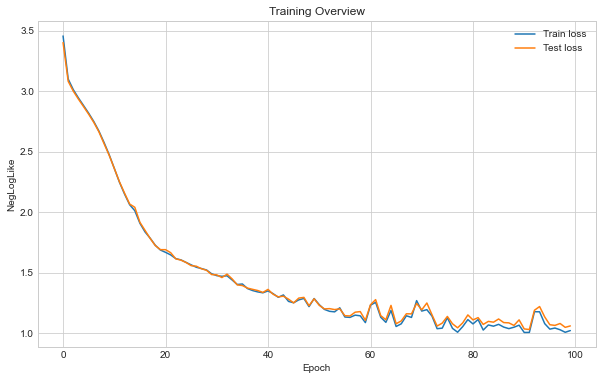

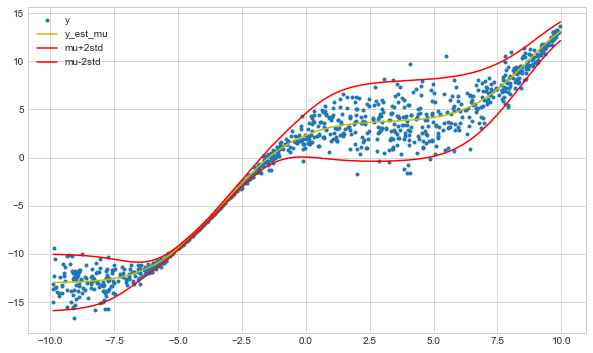

In [7]:
model_dnm = DeepNormalModel(1)

learning_rate = 0.05
optimizer = torch.optim.Adam(model_dnm.parameters(), lr=learning_rate)

loss_train, loss_test = train_dl(
    model_dnm,
    dataloader_train,
    dataloader_test,
    loss_fn_loglike,
    optimizer,
    epochs=100,
)

plot_loss(loss_train, loss_test)
plot_model_results(model_dnm, x_train, y_train)

 The training code is hidden inside the helper functions.

 ## PyTorch Lightning approach
 In PyTorch Lightning we subclass the `LightningModule` and bring in a couple of the above PyTorch helpers into the class definition.
 The training code becomes shorter as the Lightning Trainer class does most of the work for us...

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type   | Params
----------------------------------------
0 | hidden       | Linear | 20    
1 | mean_linear  | Linear | 11    
2 | scale_linear | Linear | 11    
----------------------------------------
42        Trainable params
0         Non-trainable params
42        Total params
0.000     Total estimated model params size (MB)
Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s, loss=3.46, v_num=0]/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the

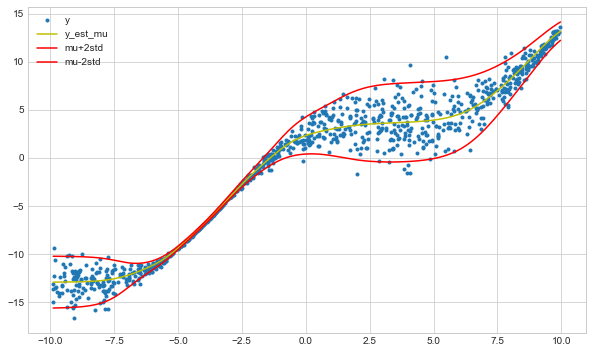

In [8]:
import pytorch_lightning as pl


class DeepNormalModelPL(pl.LightningModule):
    def __init__(self, n_inputs: int = 1, n_hidden: int = 10, learning_rate=0.05):
        super().__init__()

        self.learning_rate = learning_rate
        self.hidden = torch.nn.Linear(n_inputs, n_hidden)
        self.mean_linear = torch.nn.Linear(n_hidden, 1)
        self.scale_linear = torch.nn.Linear(n_hidden, 1)

    def forward(self, x):
        outputs = self.hidden(x)
        # outputs = torch.relu(outputs)
        outputs = torch.sigmoid(outputs)

        mean = self.mean_linear(outputs)
        scale = torch.nn.functional.softplus(self.scale_linear(outputs))

        return torch.distributions.Normal(mean, scale)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_fn_loglike(y_hat, y)
        return loss


model_lightning = DeepNormalModelPL()
trainer = pl.Trainer(max_epochs=200, progress_bar_refresh_rate=20)
trainer.fit(model_lightning, dataloader_train, dataloader_test)

plot_model_results(model_lightning, x_train, y_train)

 The trainer object is fairly extensive and gives us a lot of extras for free, some of which are explored below.

 ### Tensorboard
 Lightning by defaults allows us to can display the loss in tensorboard:

In [9]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 42170), started 1:18:31 ago. (Use '!kill 42170' to kill it.)

 ### Fit with early stopping
 To introduce early stopping we add a callback to the trainer object.
 We need to add a `validation_step` which logs the validation loss in order to use it with early stopping.
 As such we redefine the model class, we do that here by inheriting the previous class:

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type   | Params
----------------------------------------
0 | hidden       | Linear | 20    
1 | mean_linear  | Linear | 11    
2 | scale_linear | Linear | 11    
----------------------------------------
42        Trainable params
0         Non-trainable params
42        Total params
0.000     Total estimated model params size (MB)
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck.

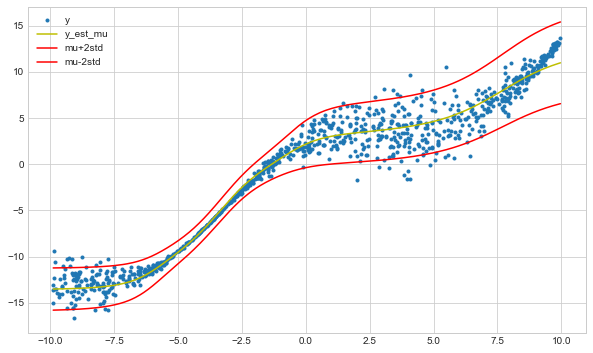

In [10]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


class DeepNormalModelPLES(DeepNormalModelPL):
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_fn_loglike(y_hat, y)
        self.log("val_loss", loss)
        return loss


model_lightning = DeepNormalModelPLES()
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[EarlyStopping(monitor="val_loss")],
    progress_bar_refresh_rate=20,
)
trainer.fit(model_lightning, dataloader_train, dataloader_test)

plot_model_results(model_lightning, x_train, y_train)

 The model stopped training earlier :)

 ### Auto learning rate finder
 Setting `auto_lr_find=True` in the trainer object sets a more optimal learning rate for the training.
 This should generally make learning faster if we don't have much knowledge of the optimal parameter.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type   | Params
----------------------------------------
0 | hidden       | Linear | 20    
1 | mean_linear  | Linear | 11    
2 | scale_linear | Linear | 11    
----------------------------------------
42        Trainable params
0         Non-trainable params
42        Total params
0.000     Total estimated model params size (MB)
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

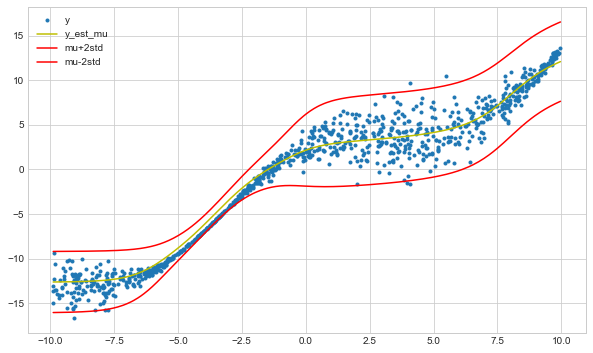

In [11]:
model_lightning = DeepNormalModelPLES()
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[EarlyStopping(monitor="val_loss")],
    auto_lr_find=True,
    progress_bar_refresh_rate=20,
)
trainer.tune(model_lightning, dataloader_train, dataloader_test)
trainer.fit(model_lightning, dataloader_train, dataloader_test)

plot_model_results(model_lightning, x_train, y_train)

 The model stopped training even earlier :)

 ### Reloading models
 The `trainer` object saves checkpoints as it goes, so it's easy to reload the model at a later date.
 We reload it using the `load_from_checkpoint` which is inherited from the base lightning class
 and show that the results are the same as before:

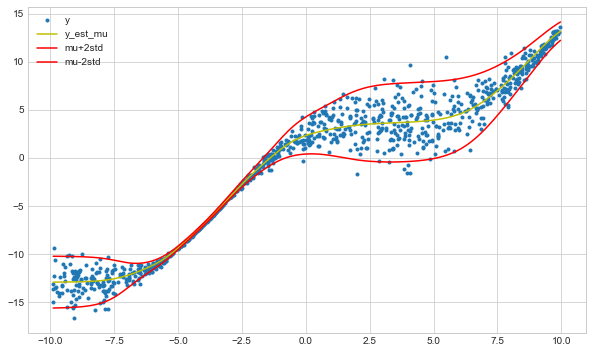

In [12]:
# test checkpoint reload
model_lightning_load = DeepNormalModelPL.load_from_checkpoint(
    "lightning_logs/version_0/checkpoints/epoch=199-step=3199.ckpt"
)
plot_model_results(model_lightning_load, x_train, y_train)

 ## Conclusion
 PyTorch Lightning seems pretty handy! It gives some of the features of Keras which makes the code much neater.
 I think I'll be using PyTorch Lightning along side PyTorch going forwards!